In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#the imports below let you use functions to train test and creat ML models.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from statsmodels.formula.api import ols
import statsmodels.api as sm
#the 4 imports below let you visualize decision trees.
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#The 3 imports below let your create different types of decision tree Classifiers.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#the last import ignores pink patchnote warnings
import warnings
warnings.filterwarnings("ignore")

# The Dataset

It is data collected by the University of California Irvine from patients admitted to the hospital. The data contains various metrics of heart health with the target variable being if heart disease is present or not present in the patient. The full data set contains 76 variables but for our project we will only be using the 14 variables with 303 entries from the Cleaveland dataset. 

In [2]:
# Creating a dataframe by importing the Heart CSV file
df = pd.read_csv("heart.csv")

In [3]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


## EDA
Now to look at the distribution, look at the data types and observe if there are any null values or missing data.

In [4]:
print('The number of samples:', df.shape[0])

The number of samples: 303


In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
df['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [7]:
df = df.astype(np.int64, copy= False)

### Creating Dummies for Categorical Variables:
So the following section of code deals with creating dummy variables for the vategorical data in our dataset so the results are easier to interpret.

In [8]:
df.columns = ['age', 'sex', 'cp_type', 'rbs', 'chol', 'fbs', 'rest_ecg', 'max_hra',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'vessels', 'thal_test', 'target']

In [9]:

df['sex'] = np.where(df['sex']==0, 'female', 'male')

cp_type = {0:'typical angina', 1:'atypical angina', 2:"non-anginal pain", 3:'asymptomatic'}
df.replace({'cp_type':cp_type}, inplace=True)

df['fbs'] = np.where(df['fbs']==0, 'lower than 120mg/ml', 'greater than 120mg/ml')

rest_ecg = {0:'normal', 1:'ST-T wave abnormality', 2:'left ventricular hypertrophy'}
df.replace({'rest_ecg':rest_ecg}, inplace=True)

df['exercise_induced_angina'] = np.where(df['exercise_induced_angina']==0, 'no', 'yes')

st_slope = {0:'upsloping', 1:"flat", 2:"downsloping"}
df.replace({"st_slope":st_slope}, inplace=True)

thal_test = {1: "normal", 2: "fixed defect", 3: "reversable defect"}
df.replace({"thal_test": thal_test}, inplace=True)


In [10]:
df['vessels']=df['vessels'].astype(str)

df.dtypes

age                         int64
sex                        object
cp_type                    object
rbs                         int64
chol                        int64
fbs                        object
rest_ecg                   object
max_hra                     int64
exercise_induced_angina    object
st_depression               int64
st_slope                   object
vessels                    object
thal_test                  object
target                      int64
dtype: object

In [11]:
df.columns

Index(['age', 'sex', 'cp_type', 'rbs', 'chol', 'fbs', 'rest_ecg', 'max_hra',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'vessels',
       'thal_test', 'target'],
      dtype='object')

In [12]:
df.dtypes

age                         int64
sex                        object
cp_type                    object
rbs                         int64
chol                        int64
fbs                        object
rest_ecg                   object
max_hra                     int64
exercise_induced_angina    object
st_depression               int64
st_slope                   object
vessels                    object
thal_test                  object
target                      int64
dtype: object

In [13]:
df = pd.get_dummies(df)


In [14]:
df.head(1)
df.drop(['cp_type_non-anginal pain','rest_ecg_normal','thal_test_0','st_slope_flat','vessels_0','exercise_induced_angina_no','sex_female','fbs_lower than 120mg/ml'], axis=1, inplace=True)

### Distribution of variables
In the section below we are doing more exploratory analysis into the distributions of the variables.

In [15]:
#We can see the mean, std, and quantile range of the data.
df.describe()

,age,rbs,chol,max_hra,st_depression,target,sex_male,cp_type_asymptomatic,cp_type_atypical angina,cp_type_typical angina,...,exercise_induced_angina_yes,st_slope_downsloping,st_slope_upsloping,vessels_1,vessels_2,vessels_3,vessels_4,thal_test_fixed defect,thal_test_normal,thal_test_reversable defect
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,0.765677,0.544554,0.683168,0.075908,0.165017,0.471947,...,0.326733,0.468647,0.069307,0.214521,0.125413,0.066007,0.016502,0.547855,0.059406,0.386139
std,9.082101,17.538143,51.830751,22.905161,1.070933,0.498835,0.466011,0.265288,0.371809,0.500038,...,0.469794,0.499842,0.254395,0.411169,0.331734,0.248704,0.127605,0.498528,0.236774,0.487668
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#prints the percentage of heart disease cases, to no heart disease cases in the dataset.
print ('Heart Disease Cases: {}%'.format(len(df[df['target']==1])/len(df)*100))
print ('No Heart Disease Cases: {}%'.format(len(df[df['target']==0])/len(df)*100))

Heart Disease Cases: 54.45544554455446%
No Heart Disease Cases: 45.54455445544555%


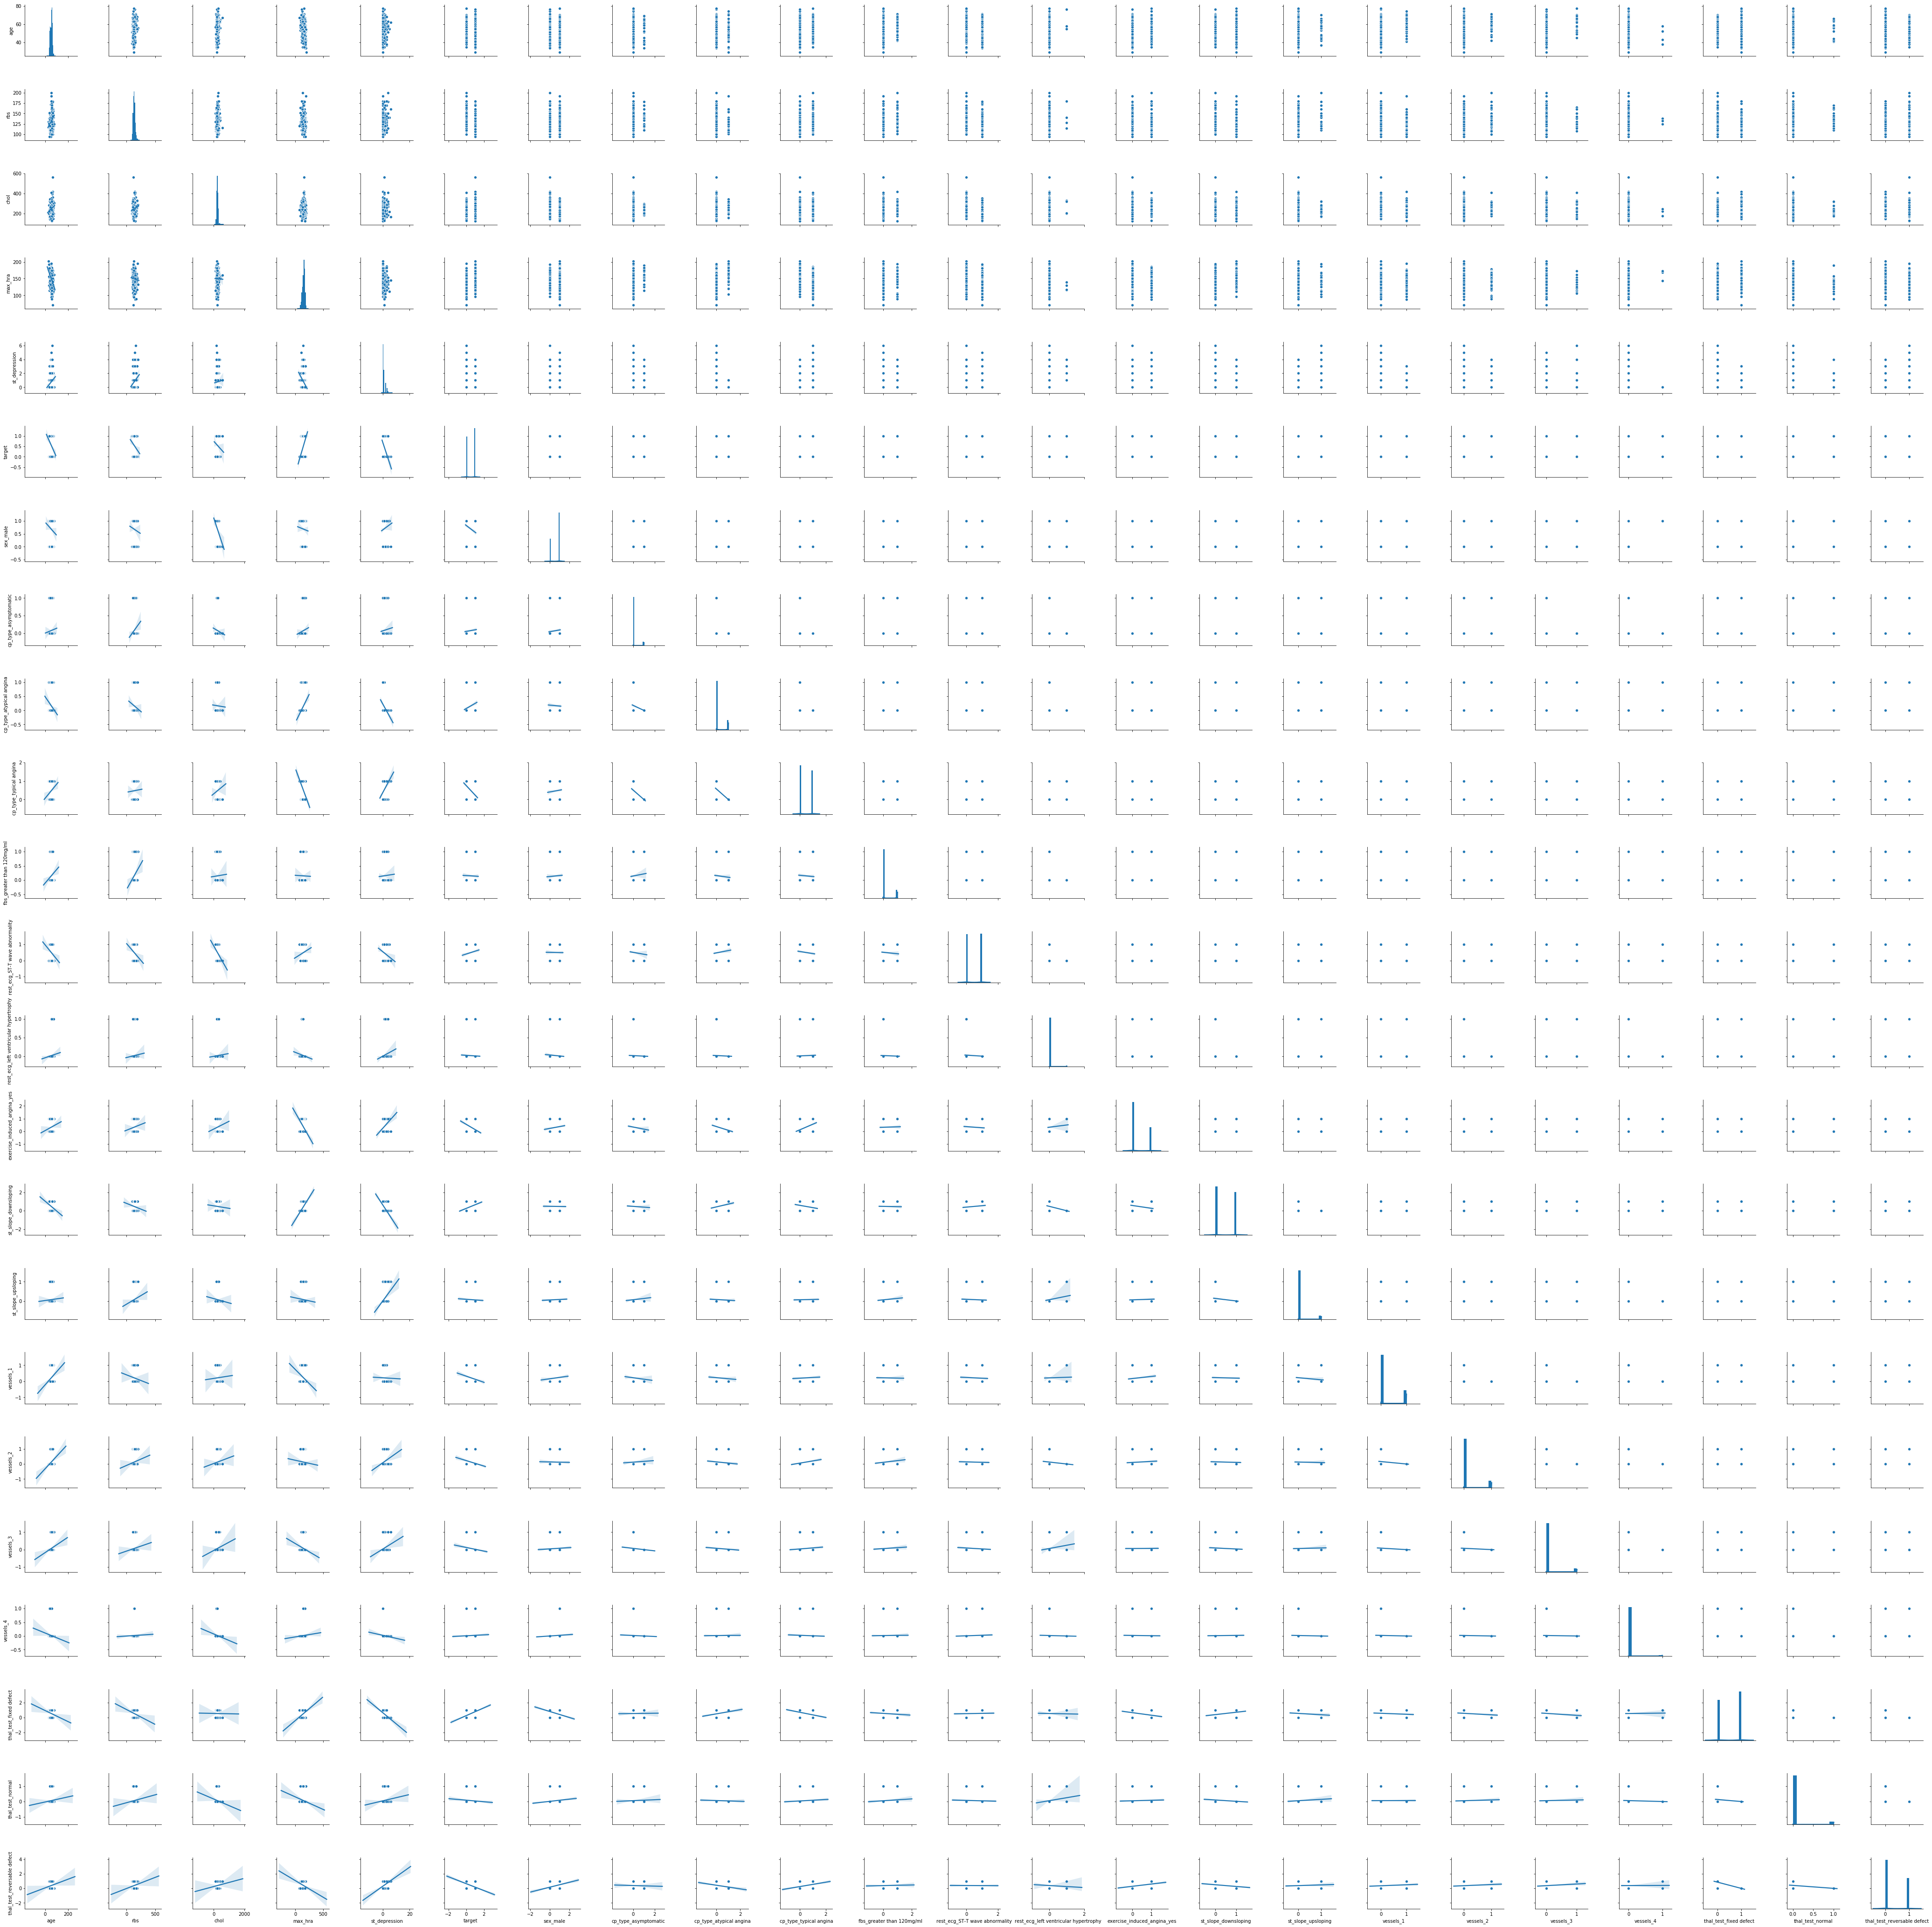

In [17]:
# The pair plot below can be used to visually see the correlation of the variables amongst each other,
# as well as the distributions the of each varibale in the form of a histogram across the diagnol.

fig = sns.pairplot(df)
fig.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
fig.map_diag(sns.kdeplot, lw=3)
plt.show()

# The code below makes a graph very similar to the pair plot graph but it shows the variation in 
# the data as a density plot instead of a histogram. So we have commented it out for now.
#fig = sns.PairGrid(df, diag_sharey=False)
#fig.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
#fig.map_diag(sns.kdeplot, lw=3)
#plt.show()

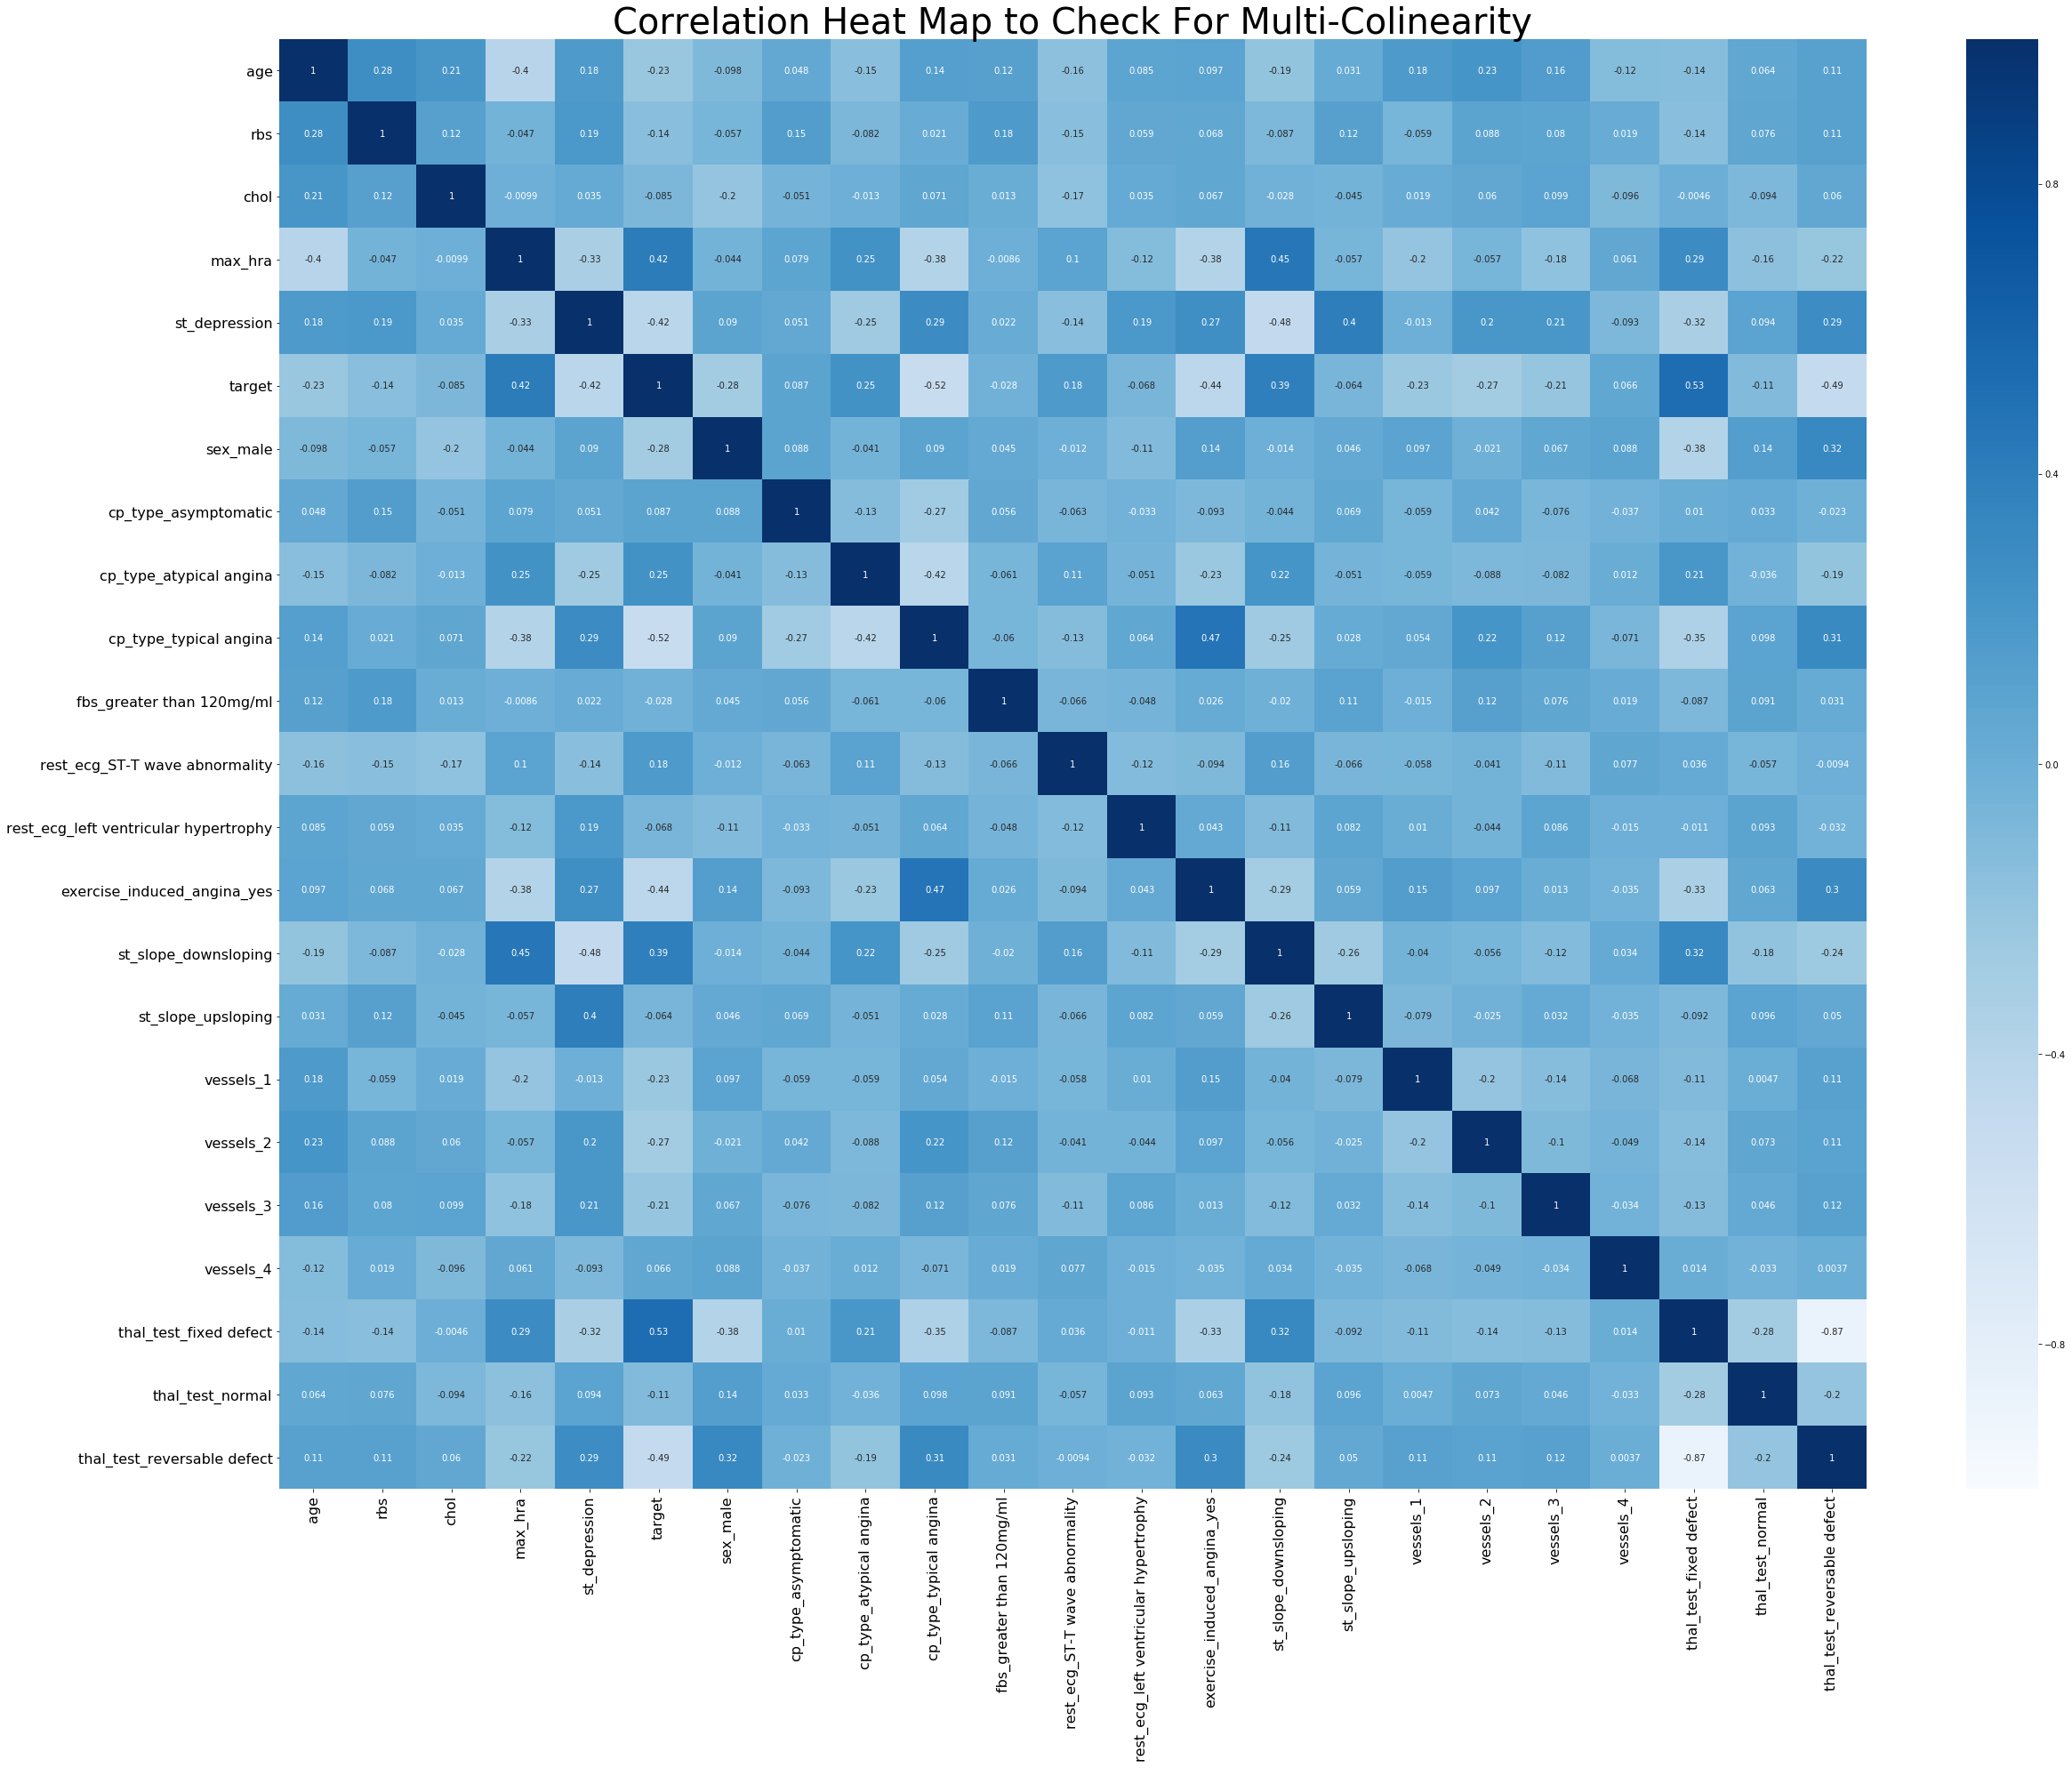

In [18]:
# This code creates a heat map of the correlation of each variable amongst eachother. We can use this to see if there are any
# issue of multi-colinearity with the model. We check the correlation between each explanatory variable.
fig, ax = plt.subplots(figsize=(40,30)) 
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Correlation Heat Map to Check For Multi-Colinearity", fontsize=40)
sns.heatmap(df.corr(), vmin=-1, annot= True, cmap='Blues')
plt.show()

### Heatmap of variables to check correlations.
We can use this heatmap to see how the variables correlate with each other. We can use this matrix to see if there is any multicolinearity.

### Splitting up the data for modelling 
We are going to create a split of the data for training and validation purposes. We will be using half of the data in the dataset for training and the other half for testing.

In [19]:
X = df.drop('target', axis=1)
Y = df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5, stratify = Y)

### Decision Tree


In [20]:
decision_tree = DecisionTreeClassifier(min_samples_split=5,min_impurity_split=0.005, class_weight='balanced')
decision_tree.fit(X_train, Y_train)
print ('model accuracy: {:.3f}%'.format(decision_tree.score(X_test,Y_test)*100))

model accuracy: 67.105%


In [21]:
pd.crosstab(Y_test, decision_tree.predict(X_test))

col_0,0,1
target,,
0,48,21
1,29,54


In [22]:
cross_val_score(decision_tree, X, Y, cv=5).mean()

0.739344262295082

In [23]:
#Random Forest
# random_forest = RandomForestClassifier(class_weight='balanced', n_estimators=100)

# random_forest.fit(X_train, Y_train)

#print ('model accuracy: {:.3f}%'.format(random_forest.score(X_test,Y_test)*100))

In [24]:
#pd.crosstab(Y_test, random_forest.predict(X_test))

In [25]:
#cross_val_score(random_forest,X, Y, cv=5).mean()
#The random forest gives us the best model as during cross validation it offers the least variance between the accuracy of the 8 splits, thus overfitting has been reduced for this model compared to the logistic regression model and the decision tree.

## Linear Regression

In [26]:
clf = LinearRegression()
clf.fit(X_train, Y_train)
class_rate = clf.score(X_test, Y_test)
print(clf.coef_)
print('model accuracy: {:.3f}%'.format((class_rate*100)))

[ 1.10705223e-03  6.69041111e-05 -1.02482314e-03  1.00516345e-03
 -7.05992339e-02 -1.83667786e-01  2.18215768e-02 -5.80339206e-04
 -1.07298581e-01 -4.03244119e-02  1.07321272e-03 -4.15287622e-01
 -5.99756702e-02  1.74150358e-01  1.16003457e-01 -2.40192323e-01
 -3.31221366e-01 -4.74666048e-01 -1.16871384e-01  4.92021555e-01
  4.05391220e-01  2.54699351e-01]
model accuracy: 45.483%


Hmmmm this seems to be giving us a very low classification rate. We should try to create dummies for the categorical variables and see the effect on the model.

In [27]:
cross_val_score(clf,X, Y, cv=5).mean()


0.07461880978560789

In [28]:
# df.to_csv(r'C:\Users\shaha\OneDrive\Desktop\personalprojects\Heart Disease\Heart_with_dummies.csv', header=True)

In [29]:
# dfnew = pd.read_csv("Heart_dummies_fixed.csv")
# dfnew[:1]

In [30]:

Xd = df.drop('target', axis=1)
Yd = df['target']

Xd_train, Xd_test, Yd_train, Yd_test = train_test_split(Xd, Yd, test_size=.6, stratify = Yd)
#Logistic Regression
#Using a simple logistic regression as a baseline we can see how our model does.
logrmodel = LogisticRegression(solver='liblinear', class_weight='balanced')
logrmodel.fit(Xd_train, Yd_train)
print ("40% validation accuracy: ", logrmodel.score(Xd_test, Yd_test))
pd.crosstab(Yd_test, logrmodel.predict(Xd_test))
print(cross_val_score(logrmodel, Xd, Yd, cv=6))
#The logistic model performs fairly well, except during cross validation when there are 8 splits there is large variance in
# the prediction accuracy which means that the model may be over fitting. 
# Thus we may need to take a different approach such as a decision tree.


40% validation accuracy:  0.8241758241758241
[0.88235294 0.84313725 0.88235294 0.82       0.88       0.82      ]


In [31]:


# Xd_train, Xd_test, Yd_train, Yd_test = train_test_split(Xd, Yd, test_size=.6, stratify = Yd)

In [32]:
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

params = np.append(logrmodel.intercept_,logrmodel.coef_)
predictions = logrmodel.predict(Xd)

newX = pd.DataFrame({"Constant":np.ones(len(Xd))}).join(pd.DataFrame(Xd))
MSE = (sum((Yd-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,6)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
myDF3= myDF3[1:]

print(myDF3)

    Coefficients  Standard Errors  t values  Probabilites
1        -0.0170            0.003    -5.241      0.000000
2         0.0057            0.001     3.807      0.000171
3        -0.0074            0.000   -15.056      0.000000
4         0.0193            0.001    14.128      0.000000
5        -0.7679            0.030   -25.803      0.000000
6        -0.6188            0.059   -10.497      0.000000
7         0.4387            0.100     4.375      0.000017
8        -0.9115            0.074   -12.264      0.000000
9        -1.3655            0.066   -20.746      0.000000
10        0.2093            0.070     2.987      0.003051
11        0.5709            0.050    11.432      0.000000
12        0.0000            0.216     0.000      1.000000
13       -0.6672            0.061   -10.933      0.000000
14        0.6675            0.060    11.140      0.000000
15        0.4098            0.105     3.891      0.000123
16       -1.3113            0.065   -20.195      0.000000
17       -0.59

In [33]:
print(logrmodel.coef_)
myDF3.set_index(Xd.columns)


[[-0.01699921  0.00567859 -0.00740201  0.01932628 -0.76790985 -0.6187648
   0.43868886 -0.91150213 -1.36549842  0.20930343  0.57092779  0.
  -0.66723536  0.66747488  0.40980287 -1.31131525 -0.59801251 -0.18791645
  -0.06764642  1.42978697 -0.11487333 -0.86861377]]


,Coefficients,Standard Errors,t values,Probabilites
age,-0.0170,0.003,-5.241,0.000000
rbs,0.0057,0.001,3.807,0.000171
chol,-0.0074,0.000,-15.056,0.000000
max_hra,0.0193,0.001,14.128,0.000000
st_depression,-0.7679,0.030,-25.803,0.000000
sex_male,-0.6188,0.059,-10.497,0.000000
cp_type_asymptomatic,0.4387,0.100,4.375,0.000017
cp_type_atypical angina,-0.9115,0.074,-12.264,0.000000
cp_type_typical angina,-1.3655,0.066,-20.746,0.000000
fbs_greater than 120mg/ml,0.2093,0.070,2.987,0.003051


In [34]:
# you can train models in functions to do repeated steps of model creation in one line rather than repateing the same steps per model

In [35]:
decision_treed = DecisionTreeClassifier( max_depth=5,
             max_leaf_nodes=10, min_samples_leaf=5,
             min_samples_split=2, min_weight_fraction_leaf=0.0,)

decision_treed.fit(Xd_train, Yd_train)

print ('model accuracy: {:.3f}%'.format(decision_treed.score(Xd_test,Yd_test)*100))

model accuracy: 76.923%


In [36]:
pd.crosstab(Yd_test, decision_treed.predict(Xd_test))

col_0,0,1
target,,
0,60,23
1,19,80


In [37]:
cross_val_score(decision_treed, Xd, Yd, cv=6).mean()

0.7551633986928105

In [38]:
boosted_tree = XGBClassifier()
boosted_tree.fit(Xd_train, Yd_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [39]:

# make predictions for test data
y_pred = boosted_tree.predict(Xd_test)
predictions = [value for value in y_pred]


In [40]:
#evaluate accuracy
accuracy = accuracy_score(Yd_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.02%


In [41]:
#Split the data in to 6 sets and then tale the mean of the accuracy of the models.
cross_val_score(boosted_tree, Xd, Yd, cv=5).mean()

0.8116939890710382

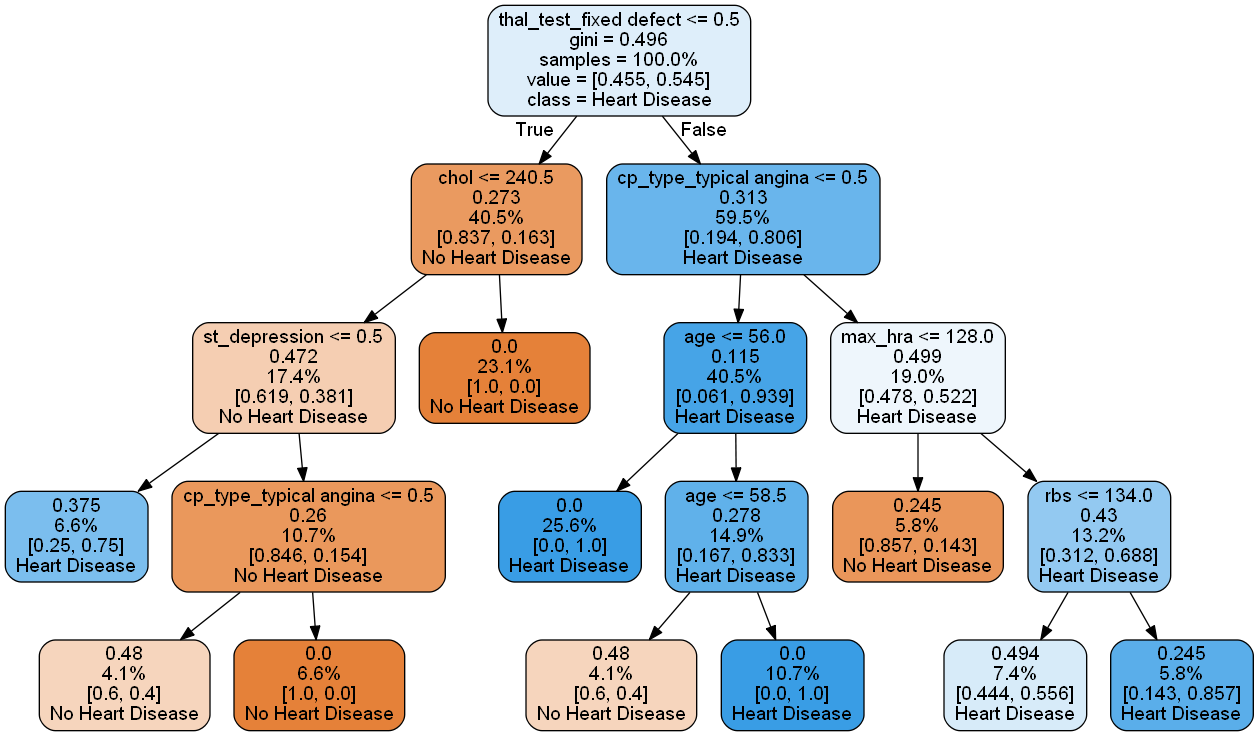

In [42]:
# Lighter Colors mean higher Gini values, Orange is No Heart Disease, Blue is Heart Disease
col_names = Xd.columns
dot_data = StringIO()
export_graphviz(decision_treed, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,
                feature_names=col_names, proportion=True,label='root',
                class_names=['No Heart Disease','Heart Disease'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [43]:
#import statsmodels
#probit_model = statsmodels.discrete.discrete_model.Probit(Yd, Xd)


In [45]:
#df.to_csv(r'C:\Users\shaha\OneDrive\Desktop\personalprojects\Heart Disease\Heart_final.csv', header=True)